# Unsupervised learning - PCA and clustering example

In this example we will be exploring country data provided by the [World Bank](https://datacatalog.worldbank.org/home). It includes population statistics, electricity, and technology adoption, as well as economic indicators such as inflation and trade data.

In [35]:
# Load libraries.
import pandas as pd
import numpy as np

# Visualisation libraries.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer # You will need the scikit-learn version >= 0.22
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

## Exploring the data

First, let us explore and clean the dataset to get ready for the analysis.

In [36]:
# Load dataset and use the country column as index.
df = pd.read_csv("countries.csv",index_col='Country')
df.head()

,Country Groups,BX.KLT.DINV.WD.GD.ZS,EG.ELC.ACCS.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.PC,FP.CPI.TOTL.ZG,IT.CEL.SETS.P2,IT.NET.USER.ZS,NE.EXP.GNFS.ZS,NE.IMP.GNFS.ZS,NY.GDP.PCAP.CD,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.IN,SP.DYN.TFRT.IN,SP.POP.GROW,SP.URB.TOTL.IN.ZS
Country,,,,,,,,,,,,,,,,,,,,
CEB,Central Europe and the Baltics,1.556,100.000,14.538,6.820,1.841,122.192,58.599,52.333,53.039,12567.128,77.040,189.578,10.543,11.430,6.019,75.295,1.465,-0.363,62.059
CSS,Caribbean small states,4.658,93.115,9.096,9.277,3.250,113.628,35.408,44.936,43.747,8726.326,121.929,200.568,17.556,7.436,18.406,72.252,2.152,0.642,42.083
EAP,East Asia & Pacific (excluding high income),3.796,94.997,16.472,5.106,3.790,69.906,28.957,30.573,27.096,4007.324,91.718,134.835,14.439,7.019,19.100,73.482,1.844,0.713,47.697
EAR,Early-demographic dividend,2.074,79.455,26.481,2.120,4.580,68.069,12.835,27.711,27.371,2926.484,150.596,214.979,22.915,7.029,40.042,67.956,2.763,1.535,42.113
EAS,East Asia & Pacific,2.931,95.496,13.729,5.702,3.248,73.657,34.270,32.153,29.113,7674.476,86.703,130.465,13.881,7.095,18.136,74.384,1.797,0.675,51.791


In [37]:
# Printing the shape of the dataset
print('Number of countries: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of countries: 44 Number of features: 20


First, let us clean the data set ready for the analysis. We rename columns so that it is clearer what they represent.


In [38]:
# Replace variables names to more meaningful ones
d = {   'BX.KLT.DINV.WD.GD.ZS': 'FDI',
        'EG.ELC.ACCS.ZS':'AccessElec',
        'EG.FEC.RNEW.ZS':'Renewable(%)',
        'EN.ATM.CO2E.PC':'CO2',
        'FP.CPI.TOTL.ZG':'CPI',
        'IT.CEL.SETS.P2':'Cellphone',
       'IT.NET.USER.ZS': 'Internet(%)',
       'NE.EXP.GNFS.ZS': 'Exports(%)',
       'NE.IMP.GNFS.ZS': 'Imports(%)',
       'NY.GDP.PCAP.CD': 'GDP($)',
       'SP.DYN.AMRT.FE': 'MortalityFem',
       'SP.DYN.AMRT.MA': 'MortalityMale',
       'SP.DYN.CBRT.IN': 'BirthRate',
       'SP.DYN.CDRT.IN': 'DeathRate',
       'SP.DYN.IMRT.IN': 'MortalityInfant',
       'SP.DYN.LE00.IN': 'LifeExp',
       'SP.DYN.TFRT.IN': 'FertilityRate',
       'SP.POP.GROW': 'PopGrowth(%)',
       'SP.URB.TOTL.IN.ZS': 'UrbanPop(%)'}
df.rename(columns = d, inplace = True)
df.columns

Index(['Country Groups', 'FDI', 'AccessElec', 'Renewable(%)', 'CO2', 'CPI',
       'Cellphone', 'Internet(%)', 'Exports(%)', 'Imports(%)', 'GDP($)',
       'MortalityFem', 'MortalityMale', 'BirthRate', 'DeathRate',
       'MortalityInfant', 'LifeExp', 'FertilityRate', 'PopGrowth(%)',
       'UrbanPop(%)'],
      dtype='object')

Let's get a summary of the statistical properties including the mean, standard deviation, and range of each feature.

In [39]:
# To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# The describe() function gives us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() # Select relevant rows
selected_stats

,mean,std,min,max
FDI,3.39,2.11,0.27,11.56
AccessElec,76.63,26.00,23.09,100.00
Renewable(%),30.77,25.55,1.50,81.01
CO2,4.14,3.21,0.22,11.56
CPI,3.89,1.29,1.53,7.58
Cellphone,76.06,28.70,26.56,122.83
Internet(%),27.39,20.54,3.25,72.29
Exports(%),31.90,9.44,19.93,62.17
Imports(%),32.98,11.35,20.10,80.99
GDP($),8864.04,11163.53,522.03,39449.30


Next, we identify any missing values and determine which features are affected.

In [40]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing


,missing
Country Groups,0
FDI,0
AccessElec,0
Renewable(%),0
CO2,0
CPI,2
Cellphone,0
Internet(%),0
Exports(%),0
Imports(%),0


It is also often useful to determine the type of each variable. We see that we are working predominantly with continuous variables:

In [41]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, CEB to WLD
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Groups   44 non-null     object 
 1   FDI              44 non-null     float64
 2   AccessElec       44 non-null     float64
 3   Renewable(%)     44 non-null     float64
 4   CO2              44 non-null     float64
 5   CPI              42 non-null     float64
 6   Cellphone        44 non-null     float64
 7   Internet(%)      44 non-null     float64
 8   Exports(%)       44 non-null     float64
 9   Imports(%)       44 non-null     float64
 10  GDP($)           44 non-null     float64
 11  MortalityFem     44 non-null     float64
 12  MortalityMale    44 non-null     float64
 13  BirthRate        44 non-null     float64
 14  DeathRate        44 non-null     float64
 15  MortalityInfant  44 non-null     float64
 16  LifeExp          44 non-null     float64
 17  FertilityRate    44 

To visualise the distribution of the observations for each feature, we plot a histogram using pandas's ```.hist()``` function. Find more information about `hist()` in the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html).

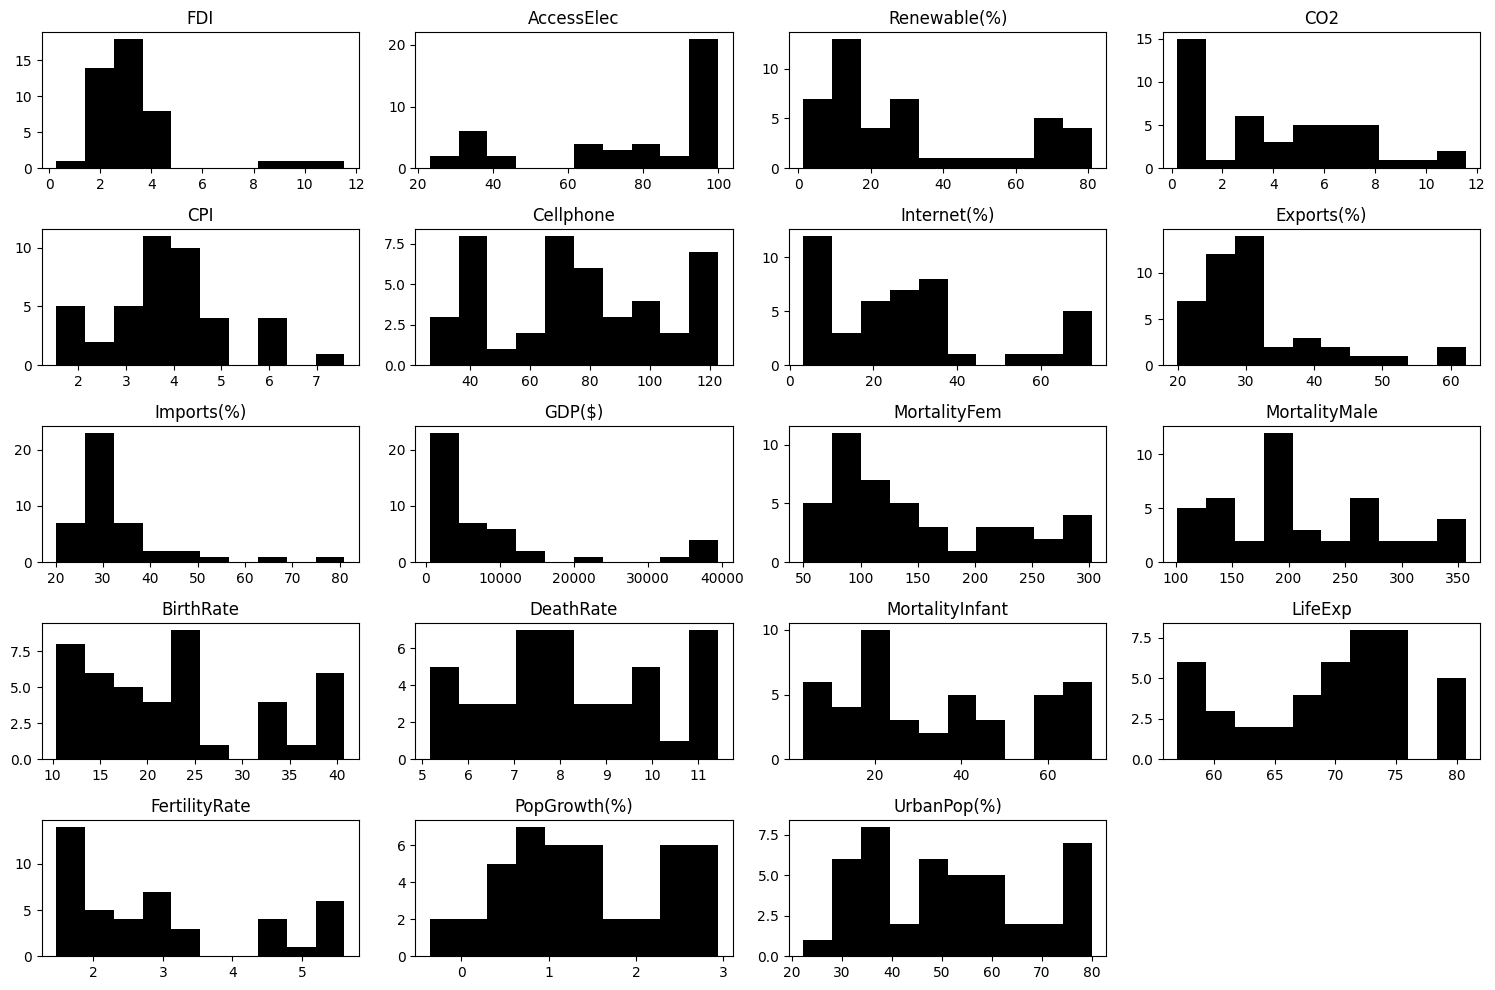

In [42]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10))
plt.tight_layout()
plt.show()

# This can also be done for each column individually by calling hist on
# that column rather than the whole dataframe


We can compile the tabular information we have so far into a single dataframe:

In [43]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True)
summary

,missing,mean,std,min,max
Country Groups,0,NaN,NaN,NaN,NaN
FDI,0,3.39,2.11,0.27,11.56
AccessElec,0,76.63,26.00,23.09,100.00
Renewable(%),0,30.77,25.55,1.50,81.01
CO2,0,4.14,3.21,0.22,11.56
CPI,2,3.89,1.29,1.53,7.58
Cellphone,0,76.06,28.70,26.56,122.83
Internet(%),0,27.39,20.54,3.25,72.29
Exports(%),0,31.90,9.44,19.93,62.17
Imports(%),0,32.98,11.35,20.10,80.99


Note the missing values for the CPI and the large mean values for GDP, MortalityFem, and MortalityMale.

## Missing values - KNN imputation

 KNN uses similar observations to derive a value for missing data. Explore scikit learn's documentation for more about the [KNNImputer class](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#knnimputer).

In [44]:
# Impute missing values with KNN
X = df["CPI"].values.reshape(-1,1) # reshape because we are looking at a single feature
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(X)
X_imputed = imputer.transform(X).squeeze()

comparison = pd.DataFrame(columns=["Original","Imputed"])
comparison["Original"] = df["CPI"].squeeze()
comparison["Imputed"] = X_imputed.squeeze()
print(comparison)


         Original  Imputed
Country                   
CEB          1.84     1.84
CSS          3.25     3.25
EAP          3.79     3.79
EAR          4.58     4.58
EAS          3.25     3.25
ECA          6.28     6.28
ECS          2.39     2.39
EMU          1.53     1.53
EUU          1.67     1.67
FCS          3.62     3.62
FSM           NaN     3.89
HIC          1.96     1.96
HPC          4.70     4.70
IBD          4.34     4.34
IBT          4.41     4.41
IDA          4.55     4.55
IDB          3.44     3.44
IDX          5.05     5.05
LAC          3.86     3.86
LCN          3.56     3.56
LDC          5.98     5.98
LIC          3.67     3.67
LMC          6.00     6.00
LMY          4.46     4.46
LTE          3.29     3.29
MEA          3.91     3.91
MIC          4.58     4.58
MNA          3.99     3.99
OED          1.81     1.81
OSS          3.17     3.17
PRE          3.98     3.98
PSS           NaN     3.89
PST          2.19     2.19
SSA          4.26     4.26
SSF          4.12     4.12
S

Note the imputed values for FSM and PSS.

In [45]:
# Replace missing values with imputed values
df["CPI"] = X_imputed

# Count missing values to check that there aren't any
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Country Groups,0
FDI,0
AccessElec,0
Renewable(%),0
CO2,0
CPI,0
Cellphone,0
Internet(%),0
Exports(%),0
Imports(%),0


## Correlation Analysis



Pandas offers a helpful function, ``corr``, which allows us to compute correlations between the different columns. It returns the corrlations as a matrix of values. The default correlation coefficient is the Pearson coefficient, but you can also choose the Kendall Tau or Spearman rank coefficient if appropriate.

In [46]:
# Get correlations between features
countries = df.index
corr_df = df.drop(["Country Groups"],axis=1).corr()
labels = corr_df.columns

correlations = corr_df.corr()

It is often useful to visualise these as a plot. Both pandas and seaborn have functions for plotting correlation heatmaps, but seaborn's offers more adjustabilty. We demonstrate the use of seaborn's heatmap, using a mask to remove the top triangular half of correlations, as these are repeats.


C:\Users\bianc\AppData\Local\Temp\ipykernel_23756\148147460.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)


<Axes: >

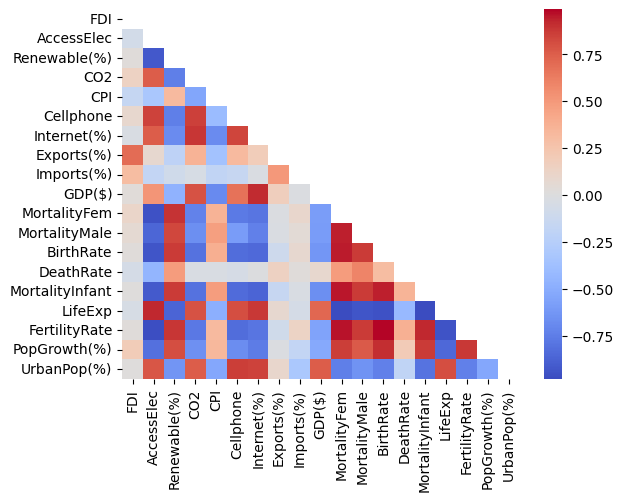

In [47]:
# Plot correlation heatmap
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")


The plot visually depicts a linear relationship between strongly correlated variables, which are represented by shades of dark red or dark blue. Red hues indicate positively correlated variables, meaning an increase in one corresponds to an increase in the other. Conversely, blue hues signify negatively correlated variables, where a decrease in one leads to an increase in the other.

## PCA

PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce these. Let's perform PCA on unstandardised data to highlight the need for scaling this data.


### Unstandardised data

In [48]:
# Run again if it does not converge the first time
np.set_printoptions(precision=2)

X = df.drop(["Country Groups"],axis=1).values.squeeze()

pca = PCA()

# Transform data
X_trans = pca.fit_transform(X)
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3703.63,-63.21,47.66,20.83,-14.68,-22.85,2.04,-6.84,3.12,8.28,-1.20,-4.01,-0.54,1.12,0.42,0.09,-0.03,0.05,-0.05
1,-137.42,-43.51,31.42,24.82,3.93,-5.92,13.86,-5.39,1.26,-5.42,8.31,1.30,1.40,-0.07,1.27,-0.22,-0.08,-0.08,0.02
2,-4856.02,-127.67,-26.32,-2.97,4.43,-4.95,1.11,-7.30,-4.94,-1.16,-1.46,-0.06,0.10,-0.16,-0.36,0.04,0.02,-0.03,0.01
3,-5937.49,-33.57,-3.18,-3.09,2.17,8.03,6.00,3.51,-0.99,-2.60,-0.84,0.04,-1.82,-0.30,1.02,0.76,0.14,-0.01,-0.01
4,-1188.89,-112.54,-25.93,-0.85,3.97,-3.77,0.11,-5.98,-4.43,0.78,-1.53,-0.45,-0.20,0.34,0.16,0.16,-0.08,0.02,0.03


In [49]:
# Calculating the standard deviation.
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [1.12e+04 9.02e+01 2.74e+01 1.52e+01 1.12e+01 8.52e+00 6.47e+00 4.84e+00
 3.65e+00 2.76e+00 2.48e+00 1.88e+00 9.17e-01 6.75e-01 4.64e-01 2.81e-01
 7.33e-02 5.75e-02 3.73e-02]


In [50]:
# Calcuating the proportion of variance explained
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [1.00e+00 6.53e-05 6.01e-06 1.85e-06 1.00e-06 5.82e-07 3.36e-07 1.88e-07
 1.07e-07 6.12e-08 4.95e-08 2.82e-08 6.75e-09 3.65e-09 1.73e-09 6.32e-10
 4.31e-11 2.65e-11 1.12e-11]


In [51]:
# Calculating the cumulative variance.
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08
 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08 1.25e+08
 1.25e+08 1.25e+08 1.25e+08]


In [52]:
# Create biplot function
def biplot(score, coeff, labels=None, points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = countries[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley), fontsize=8)

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r', head_width=0.02, alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

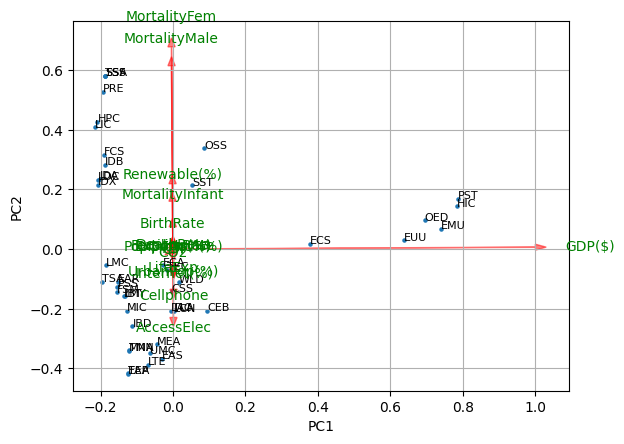

In [53]:
# Plot biplot
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(countries))
plt.show()

 From this biplot, we see that GDP and the mortality rates for males and females are the most important features as the arrows (red) for each of these dominate the biplot.

This information can also be quantified as follows:

In [54]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) # change precision to see more decimal places

# Components x features
pc1 = abs( pca.components_[0] ) # access the index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,FDI,0.000,0.003
1,AccessElec,0.001,0.229
2,Renewable(%),0.001,0.219
3,CO2,0.000,0.011
4,CPI,0.000,0.000
5,Cellphone,0.002,0.135
6,Internet(%),0.002,0.069
7,Exports(%),0.000,0.008
8,Imports(%),0.000,0.010
9,GDP($),1.000,0.006



We see that the GDP has by far the highest importance in the first principle component with a value of 1.0. Several features are relatively important for the second component but mortality for males and females are the most important with values around 0.6. These observations agree with those deduced from the biplot.

If we refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

### Standardised data

We standardise the data so that some features do not swamp the others.

In [55]:
# Standardising the data
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-3.979,2.361,-0.298,2.163,1.599,1.138,0.652,1.054,0.751,-0.248,0.120,-0.236,0.271,0.009,0.089,0.009,-0.017,-0.021,-0.004
1,-2.292,1.472,1.289,0.155,0.877,0.458,0.343,-0.523,-0.462,-0.495,0.998,0.160,-0.158,-0.124,-0.090,0.056,0.011,0.005,-0.010
2,-1.860,-1.020,0.991,-0.177,-0.074,-0.418,1.006,0.000,-0.016,-0.245,-0.199,-0.022,-0.059,0.100,-0.042,-0.004,0.010,0.004,0.003
3,0.772,-1.474,0.546,-0.146,0.045,0.279,0.250,-0.118,0.111,0.262,0.179,-0.063,-0.226,-0.117,0.193,-0.054,0.042,0.011,0.020
4,-2.365,-0.774,0.667,0.160,-0.298,-0.057,0.938,-0.080,0.052,-0.217,-0.144,-0.150,-0.006,0.044,0.033,-0.011,0.003,0.017,-0.012


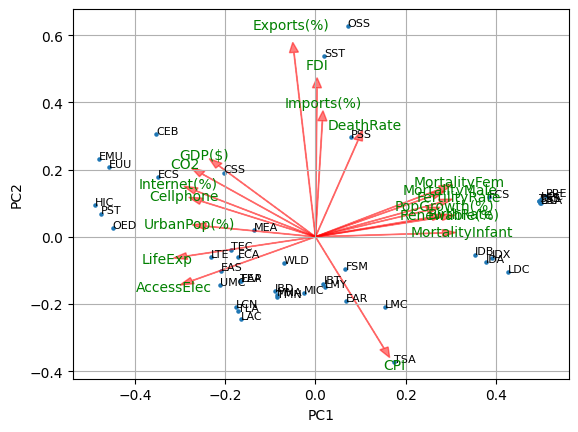

In [56]:
# Printing out the biplot.
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it. We also see that the the different features cluster together in groups.

In [57]:
# Feature importance
pc1 = abs( std_pca.components_[0] ) # Components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,FDI,0.003,0.444
1,AccessElec,0.273,0.131
2,Renewable(%),0.258,0.058
3,CO2,0.251,0.187
4,CPI,0.152,0.332
5,Cellphone,0.253,0.106
6,Internet(%),0.265,0.137
7,Exports(%),0.048,0.549
8,Imports(%),0.015,0.345
9,GDP($),0.214,0.212


Inspecting the feature importance now, we see that most of the variables contribute fairly evenly, with only some with low importance.

### Select number of principal components

Next, we will use a Scree and Cumulative Explained Variance plot to choose how many principal components to use in further analysis.

Text(0.5, 1.0, 'Cumulative Explained Variance')

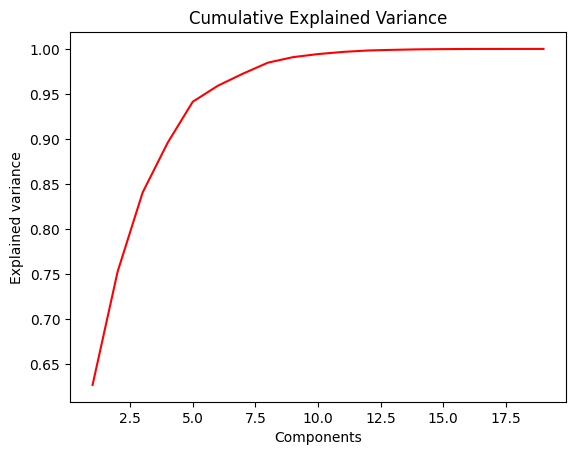

In [58]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

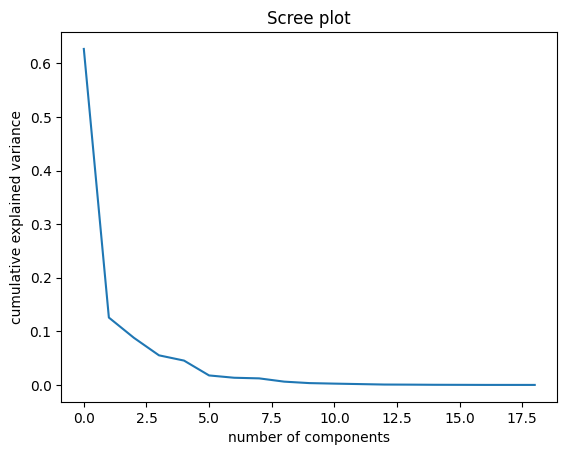

In [59]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 5 principal components together explain around 90% of the variance. We can therefore use them to perform cluster analysis. This is what we refer to as dimensionality reduction. We began with 19 variables and now we have 5 variables explaining most of the variability.


In [60]:
# Extract first 5 principal components for further analysis
pca_df = pd.DataFrame(X_std_trans[:,0:5], index = df.index)
pca_df.head()

,0,1,2,3,4
Country,,,,,
CEB,-3.979,2.361,-0.298,2.163,1.599
CSS,-2.292,1.472,1.289,0.155,0.877
EAP,-1.860,-1.020,0.991,-0.177,-0.074
EAR,0.772,-1.474,0.546,-0.146,0.045
EAS,-2.365,-0.774,0.667,0.160,-0.298


Now we will use the most important principal components to cluster the data.

## Hierarchical clustering


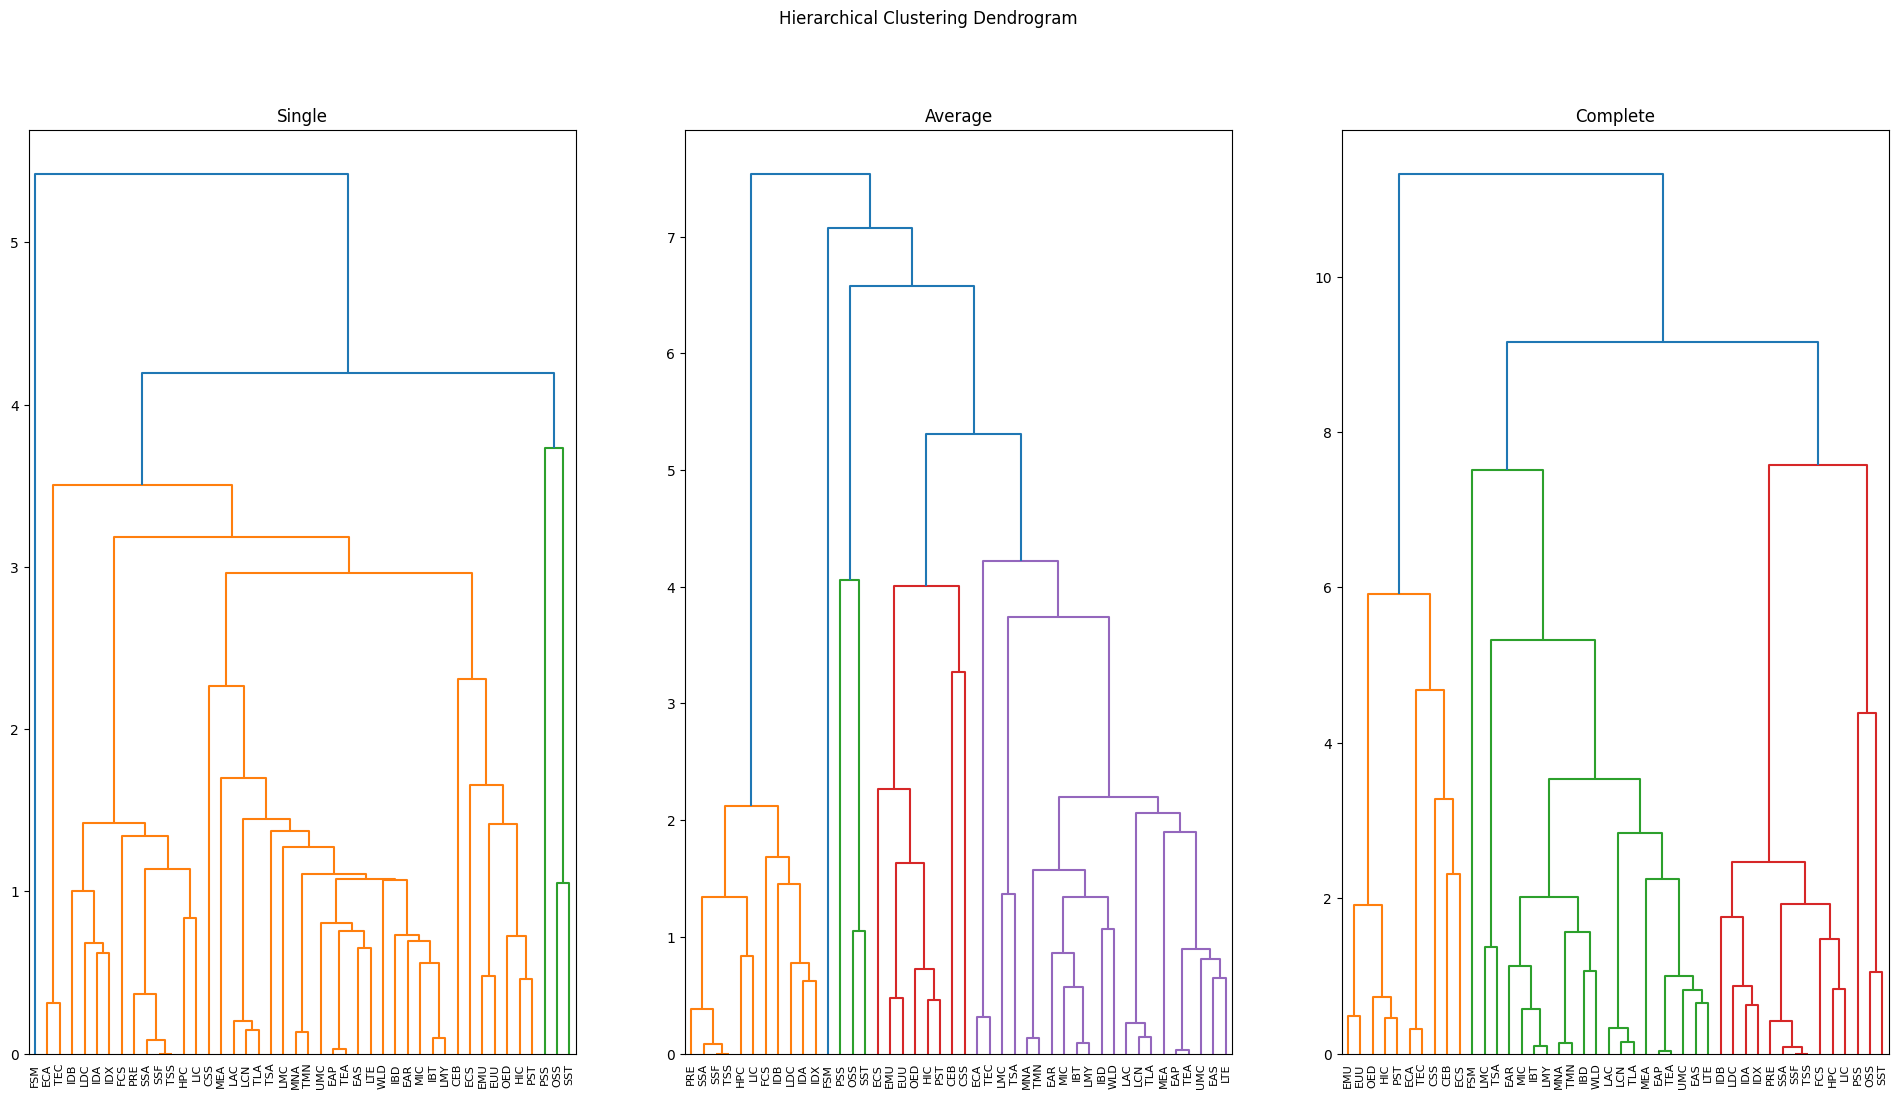

In [61]:
# Cluster data and plot a dendrogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24, 12))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) # Change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

Examine the plots to determine which linkage to use.

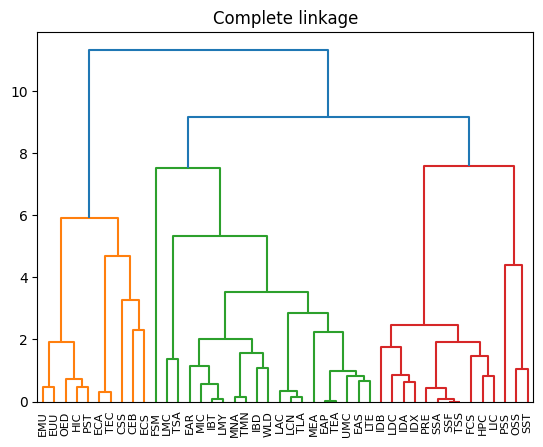

In [62]:
# Plot complete linkage dendrogram
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

We have selected the complete linkage. Where would you cut the dendrogram?

## K-means clustering

For our analysis, it seems that the shape of clusters is likely to be regular based on the PCA biplot. K will be set to 3 based on the dendrogram. A visualisation of the clusters is shown in the figure below.


C:\Users\bianc\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


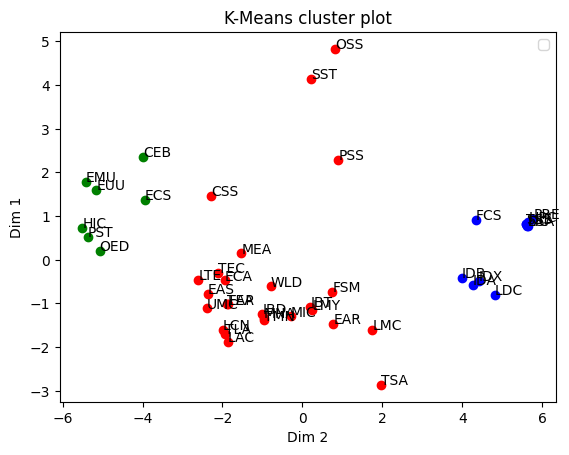

In [63]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i])

for i in range(0,len(x)):
        txt = countries[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [64]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(countries)[group0_indices]
group1 = np.array(countries)[group1_indices]
group2 = np.array(countries)[group2_indices]


print("Group 0: {}\n\n".format([df.loc[x]["Country Groups"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["Country Groups"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["Country Groups"] for x in group2]))



Group 0: ['Caribbean small states', 'East Asia & Pacific (excluding high income)', 'Early-demographic dividend', 'East Asia & Pacific', 'Europe & Central Asia (excluding high income)', 'Micronesia, Fed. Sts.', 'IBRD only', 'IDA & IBRD total', 'Latin America & Caribbean (excluding high income)', 'Latin America & Caribbean', 'Lower middle income', 'Low & middle income', 'Late-demographic dividend', 'Middle East & North Africa', 'Middle income', 'Middle East & North Africa (excluding high income)', 'Other small states', 'Pacific island small states', 'Small states', 'East Asia & Pacific (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD countries)', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Middle East & North Africa (IDA & IBRD countries)', 'South Asia (IDA & IBRD)', 'Upper middle income', 'World']


Group 1: ['Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'IDA total', 'IDA blend', 'IDA only', 'Least developed countries: UN c